In [1]:
#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy

import xarray as xr


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/homes/scollis/anaconda/envs/pyart-full/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/homes/scollis/anaconda/envs/pyart-full/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/homes/scollis/anaconda/envs/pyart-full/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/homes/scollis/anaconda/envs/pyart-full/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
radar = pyart.io.read('/lcrc/group/earthscience/radar/CACTI/corcsapr2cfrppiM1.a1.20181126.120003.nc')

In [3]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Monday November 26 at 06:00 AM CST


In [4]:
print(rlat, rlon)

-32.12641 -64.72837


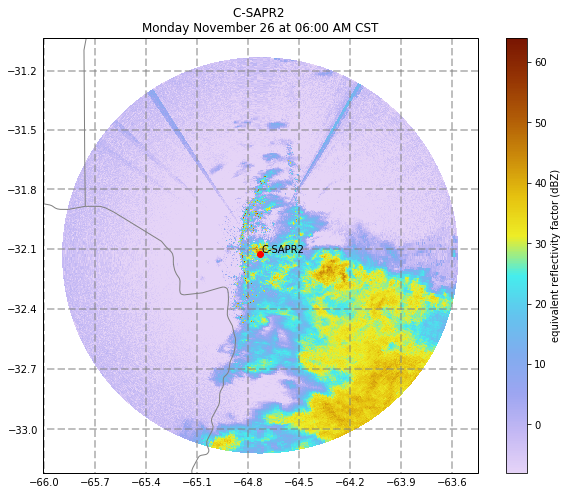

In [5]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

(0, 15)

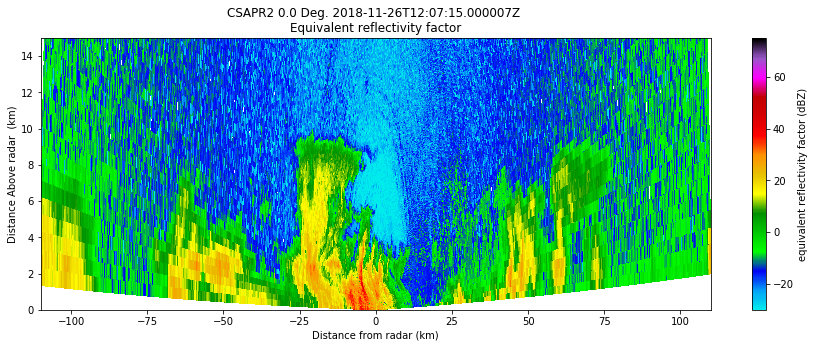

In [6]:
rhi_radar = pyart.io.read('/lcrc/group/earthscience/radar/CACTI/corcsapr2cfrhsrhiM1.a1.20181126.120715.nc')
#Set up our fig
fig = plt.figure(figsize = [15,5])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarDisplay(rhi_radar)
display.plot_rhi('reflectivity', 0)
plt.ylim([0,15])
                    


In [7]:
max_range_gate = 500

In [8]:
sweep = 0
start = radar.sweep_start_ray_index['data'][sweep]
end = radar.sweep_end_ray_index['data'][sweep]
ht = radar.gate_altitude['data'][start:end][:, 0:max_range_gate]
x = radar.gate_x['data'][start:end][:, 0:max_range_gate]
y = radar.gate_y['data'][start:end][:, 0:max_range_gate]

data = radar.fields['reflectivity']['data'][start:end][:, 0:max_range_gate]
vmin = -10
vmax = 64
floor = np.where(data < vmin)
roof = np.where(data > vmax)
data[floor] = vmin
data[roof] = vmax


In [9]:
datas = []
xs = []
ys = []
hts = []
for rsweep in range(len(rhi_radar.sweep_start_ray_index['data'])):
    rstart = rhi_radar.sweep_start_ray_index['data'][rsweep]
    rend = rhi_radar.sweep_end_ray_index['data'][rsweep]
    rht = rhi_radar.gate_altitude['data'][rstart:rend][:, 0:max_range_gate]
    rx = rhi_radar.gate_x['data'][rstart:rend][:, 0:max_range_gate]
    ry = rhi_radar.gate_y['data'][rstart:rend][:, 0:max_range_gate]

    rdata = rhi_radar.fields['reflectivity']['data'][rstart:rend][:, 0:max_range_gate]
    rfloor = np.where(rdata < vmin)
    rroof = np.where(rdata > vmax)
    rht_cut =  np.where(rht > 15000.)
    rdata[floor] = vmin
    rdata[roof] = vmax
    rdata[rht_cut] = np.ma.masked
    datas.append(rdata)
    hts.append(rht/1000.0)
    xs.append(rx/1000.0)
    ys.append(ry/1000.0)


In [10]:
print(x.shape)

(359, 500)


In [ ]:
sweeps_to_plot = [0,4]
fig = plt.figure(figsize = [15,5])
ax = fig.gca(projection='3d')

my_col = pyart.graph.cm_colorblind.HomeyerRainbow(data/vmax)


surf = ax.plot_surface((x*-1.)/1000.0, y/1000.0, ht/1000.0, rstride=1, cstride=1, facecolors = my_col,
        linewidth=0, antialiased=True, vmin = -10, vmax = 64)

for sw in sweeps_to_plot:
    rmy_col = pyart.graph.cm_colorblind.HomeyerRainbow(datas[sw]/vmax)
    rsurf = ax.plot_surface(xs[sw]*-1., ys[sw], hts[sw], rstride=1, cstride=1, facecolors = rmy_col,
            linewidth=0, antialiased=True, vmin = -10, vmax = 64)

ax.set_xlabel('Longitudinal displacement from Radar (km)')
ax.set_ylabel('Latitudinal displacement from Radar (km)')
ax.set_zlabel('Z axis')
ax.set_title(title)
    
ax.set_zlim(0, 15)


(0, 15)

Link to play with 3d on maps
https://stackoverflow.com/questions/48269014/contourf-in-3d-cartopy


In [11]:
%matplotlib qt
sweeps_to_plot = [0,4]
fig = plt.figure(figsize = [15,5])
ax = fig.gca(projection='3d')

my_col = pyart.graph.cm_colorblind.HomeyerRainbow(data/vmax)


surf = ax.plot_surface((x*-1.)/1000.0, y/1000.0, ht/1000.0, rstride=1, cstride=1, facecolors = my_col,
        linewidth=0, antialiased=True, vmin = -10, vmax = 64)

for sw in sweeps_to_plot:
    rmy_col = pyart.graph.cm_colorblind.HomeyerRainbow(datas[sw]/vmax)
    rsurf = ax.plot_surface(xs[sw]*-1., ys[sw], hts[sw], rstride=1, cstride=1, facecolors = rmy_col,
            linewidth=0, antialiased=True, vmin = -10, vmax = 64)

ax.set_xlabel('Longitudinal displacement from Radar (km)')
ax.set_ylabel('Latitudinal displacement from Radar (km)')
ax.set_zlabel('Z axis')
ax.set_title(title)
    
ax.set_zlim(0, 15)

RuntimeError: Invalid DISPLAY variable